# Problem 4 - Answers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import constants as CONSTANTS
from matplotlib.patches import Circle

Define the constants we'll use throughout. It's best practice to name constants in `ALL_CAPS`

In [2]:
# Constants
M_EARTH = 5.972E24     # Mass of the earth (kg)
R_EARTH = 6.371E6      # Radius of the earth (m)

PI = CONSTANTS.pi
GRAV = CONSTANTS.gravitational_constant
YEAR = CONSTANTS.year
DAY = CONSTANTS.day

In [3]:
# We can reuse this from Part I but now use the mass of the Earth, not the Sun!
def update_function(t, X):
    
    # Get coordinates and velocity
    x_pos, y_pos, x_vel, y_vel = X
    
    # Calculate radial distance
    radial_dist = np.sqrt(x_pos ** 2 + y_pos ** 2)
    
    # Calculate each component of acceleration
    x_acc = - GRAV * M_EARTH * x_pos / (radial_dist ** 3)
    y_acc = - GRAV * M_EARTH * y_pos / (radial_dist ** 3)
    
    return [x_vel, y_vel, x_acc, y_acc]

## Closest Approach

In [4]:
# Evaluation times
t_eval = np.linspace(0.0, 100.0 * DAY, 1000000)

In [5]:
# Asteroid's initial position (polar coords)
initial_angle = 3 * PI / 4           # radians
initial_radius = 1000.0 * R_EARTH    # metres

# Asteroid's initial velocity (polar coords)
initial_radial_vel = - 1000.0        # metres per second
initial_perpnd_vel = 13.0            # metres per second (+ve is anticlockwise)

# Convert to cartesian position
asteroid_x0 = initial_radius * np.cos(initial_angle)
asteroid_y0 = initial_radius * np.sin(initial_angle)

# ...and velocity
asteroid_vx0 = initial_radial_vel * np.cos(initial_angle) - initial_perpnd_vel * np.sin(initial_angle)
asteroid_vy0 = initial_radial_vel * np.sin(initial_angle) + initial_perpnd_vel * np.cos(initial_angle)

# Asteroid initial state vector
X_0 = np.array([asteroid_x0, asteroid_y0, asteroid_vx0, asteroid_vy0])

# Integrate
solution = solve_ivp(update_function, [0.0, t_eval[-1]], X_0, method='Radau', t_eval=t_eval)

# Get the solution
x, y, vx, vy = solution.y

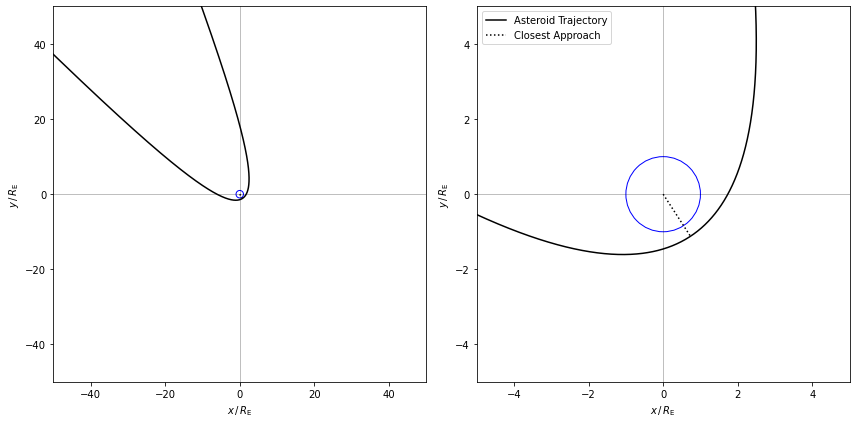

In [6]:
fig, ax = plt.subplots(1, 2)

for a in ax:

    earth = Circle((0.0, 0.0), radius=1.0, facecolor='w', edgecolor='b', label='Earth')
    a.add_artist(earth)

    a.plot(x / R_EARTH, y / R_EARTH, label='Asteroid Trajectory', color='k', alpha=1.0)

    a.plot([0.0, x[np.argmin(np.hypot(x, y))]/ R_EARTH], [0.0, y[np.argmin(np.hypot(x, y))]/ R_EARTH], 'k:', label='Closest Approach')
    a.axhline(0.0, linewidth=0.5, alpha=0.5, color='k')
    a.axvline(0.0, linewidth=0.5, alpha=0.5, color='k')

    a.set(xlim=[-5, 5], ylim=[-5, 5], 
          xlabel='$x\,/\,R_\mathrm{E}$', ylabel='$y\,/\,R_\mathrm{E}$')

ax[1].legend()
ax[0].set(xlim=[-50, 50], ylim=[-50, 50])
    
fig.set_size_inches(12, 6)
fig.tight_layout()
fig.savefig('./asteroid_initial_trajectory.pdf')
plt.show()

The closest approach occurs when the radius is at a minimum

In [7]:
closest_approach_index = np.argmin(np.hypot(x, y))

In [8]:
print('Closest approach distance = %.2f R_E' % (np.hypot(x, y)[closest_approach_index] / R_EARTH))
print('Time of closest approach = %.2f days' % (t_eval[closest_approach_index] / DAY))
print('Speed at closest approach = %.2f km/s' % (np.hypot(vx, vy)[closest_approach_index] / 1.0E3))

Closest approach distance = 1.34 R_E
Time of closest approach = 65.22 days
Speed at closest approach = 9.71 km/s


## Impact Probability

In [9]:
# Get normally distributed samples of initial radius
# (more samples = more accurate estimate)
N_SAMPLES = 100
radius_distribution = np.random.normal(initial_radius, 150.0 * R_EARTH, N_SAMPLES)

In [10]:
x, y = [], []

for radius_sample in radius_distribution:

    # This is the same as above but we swap the radius for the 
    # randomly generated sample
    asteroid_x0 = radius_sample * np.cos(initial_angle)
    asteroid_y0 = radius_sample * np.sin(initial_angle)
    asteroid_vx0 = initial_radial_vel * np.cos(initial_angle) - initial_perpnd_vel * np.sin(initial_angle)
    asteroid_vy0 = initial_radial_vel * np.sin(initial_angle) + initial_perpnd_vel * np.cos(initial_angle)
    X_0 = np.array([asteroid_x0, asteroid_y0, asteroid_vx0, asteroid_vy0])

    # Integrate the equations
    solution = solve_ivp(update_function, [0.0, t_eval[-1]], X_0, method='Radau', t_eval=t_eval)

    # Save the solution
    x_, y_, vx_, vy_ = solution.y
    
    # Only saving the coordinates close to the Earth to make
    # the plotting run faster
    mask = np.hypot(x_, y_) < 100.0 * R_EARTH
    if mask.sum() > 0.0:
        x.append(x_[mask])
        y.append(y_[mask])

In [11]:
# For each of the runs above we find the closest approach
closest_approaches = np.array([np.hypot(x[i], y[i]).min() for i in range(len(x))])

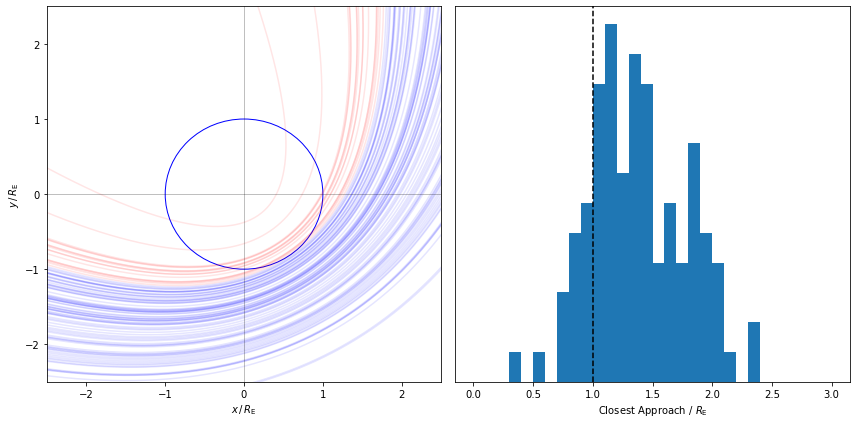

In [12]:
fig, ax = plt.subplots(1, 2)

# Plot the earth as a circle
earth = Circle((0.0, 0.0), radius=1.0, facecolor='w', edgecolor='b', label='Earth')
ax[0].add_artist(earth)

# Loop over and plot each sample orbit, hits in red, misses in blue
for i in range(len(x)):
    colour = 'r' if closest_approaches[i] < R_EARTH else 'b'
    ax[0].plot(x[i] / R_EARTH, y[i] / R_EARTH, color=colour, alpha=0.1)
      
ax[0].axhline(0.0, linewidth=0.5, alpha=0.5, color='k')
ax[0].axvline(0.0, linewidth=0.5, alpha=0.5, color='k')
ax[0].set(xlim=[-2.5, 2.5], ylim=[-2.5, 2.5],
       xlabel='$x\,/\,R_\mathrm{E}$', ylabel='$y\,/\,R_\mathrm{E}$')

# Histogram of closest approaches, everything with r < R_E is a hit
ax[1].hist(closest_approaches / R_EARTH, bins=np.linspace(0.0, 3.0, 31))
ax[1].axvline(1.0, linestyle='dashed', color='k')
ax[1].set(xlabel='Closest Approach / $R_\mathrm{E}$', yticks=[], ylabel='')

fig.set_size_inches(12, 6)
fig.tight_layout()
fig.savefig('./orbit_distribution.png', dpi=150)
plt.show()

The chance of the asteroid impacting is just the number of hits as a fraction of the total

In [13]:
print("Impact probability = %.2f%%" % (100 * (closest_approaches < R_EARTH).sum() / N_SAMPLES))

Impact probability = 16.00%


## Avoiding Impact

In [14]:
# Asteroid's initial position (polar coords)
initial_angle = 3 * PI / 4                     # radians
initial_radius = 750.0 * R_EARTH    # metres

# Asteroid's initial velocity (polar coords)
initial_radial_vel = - 1000.0        # metres per second
initial_perpnd_vel = 13.0            # metres per second (+ve is anticlockwise)

# Convert to cartesian position
asteroid_x0 = initial_radius * np.cos(initial_angle)
asteroid_y0 = initial_radius * np.sin(initial_angle)

# ...and velocity
asteroid_vx0 = initial_radial_vel * np.cos(initial_angle) - initial_perpnd_vel * np.sin(initial_angle)
asteroid_vy0 = initial_radial_vel * np.sin(initial_angle) + initial_perpnd_vel * np.cos(initial_angle)

# Asteroid initial state vector
X_0 = np.array([asteroid_x0, asteroid_y0, asteroid_vx0, asteroid_vy0])

In [15]:
boost_speeds = np.linspace(0.0, 100.0, 51)     # Sample boost speeds
R_ORBIT = 50.0 * R_EARTH                       # Radius of rocket orbit

In [16]:
x, y = [], []

# Loop over the boost velocities
for BOOST_SPEED in boost_speeds:

    # Define a new update function that uses the current boost vel.
    def update_function_with_rocket(t, X):

        # Get coordinates and velocity
        x_pos, y_pos, x_vel, y_vel = X

        # Calculate radial distance
        radial_dist = np.sqrt(x_pos ** 2 + y_pos ** 2)

        # Calculate each component of acceleration
        x_acc = - GRAV * M_EARTH * x_pos / (radial_dist ** 3)
        y_acc = - GRAV * M_EARTH * y_pos / (radial_dist ** 3)

        # When the asteroid reaches the rocket's orbit, fire the booster
        # (we use a tolerance of 10.0 * earth radius to check this)
        if (np.abs(np.hypot(x_pos, y_pos) - R_ORBIT) < (10.0 * R_EARTH)):

            # Point the boost perpendicular to the asteroid's velocity
            theta = np.arctan2(x_vel, y_vel) + (np.pi / 2)
            x_vel += BOOST_SPEED * np.cos(theta)
            y_vel += BOOST_SPEED * np.sin(theta)

        return [x_vel, y_vel, x_acc, y_acc]

    # This is the same as above but we swap the radius for the 
    # randomly generated sample
    asteroid_x0 = initial_radius * np.cos(initial_angle)
    asteroid_y0 = initial_radius * np.sin(initial_angle)
    asteroid_vx0 = initial_radial_vel * np.cos(initial_angle) - initial_perpnd_vel * np.sin(initial_angle)
    asteroid_vy0 = initial_radial_vel * np.sin(initial_angle) + initial_perpnd_vel * np.cos(initial_angle)
    X_0 = np.array([asteroid_x0, asteroid_y0, asteroid_vx0, asteroid_vy0])

    # Integrate the equations
    solution = solve_ivp(update_function_with_rocket, [0.0, t_eval[-1]], X_0, method='Radau', t_eval=t_eval)

    # Save the solution
    x_, y_, vx_, vy_ = solution.y

    # Only saving the coordinates close to the Earth to make
    # the plotting run faster
    mask = np.hypot(x_, y_) < 100.0 * R_EARTH
    if mask.sum() > 0.0:
        x.append(x_[mask])
        y.append(y_[mask])

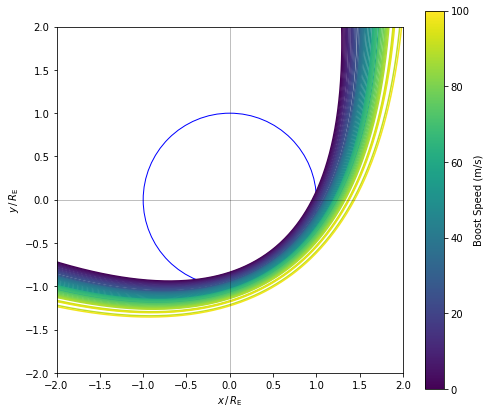

In [17]:
fig, ax = plt.subplots()

earth = Circle((0.0, 0.0), radius=1.0, facecolor='w', edgecolor='b', label='Earth')
rocket_orbit = Circle((0.0, 0.0), radius=R_ORBIT/R_EARTH, facecolor='none', edgecolor='k', linestyle='--')
ax.add_artist(earth)
ax.add_artist(rocket_orbit)

# Loop over trajectories
for i in range(len(x)):

    # Colour by boost velocity
    colour = plt.get_cmap('viridis')(i / len(boost_speeds))
    ax.plot(x[i] / R_EARTH, y[i] / R_EARTH, label='Asteroid Trajectory', color=colour, alpha=1.0)

ax.axhline(0.0, linewidth=0.5, alpha=0.5, color='k')
ax.axvline(0.0, linewidth=0.5, alpha=0.5, color='k')

ax.set(xlim=[-2, 2], ylim=[-2, 2], 
       xlabel='$x\,/\,R_\mathrm{E}$', ylabel='$y\,/\,R_\mathrm{E}$')

# Fake image plot to set the colorbar colormap
cm = ax.imshow(np.ones((10, 10)), extent=[-100, -99, -100, -99],
                cmap='viridis', vmin=boost_speeds[0], vmax=boost_speeds[-1])
    
fig.colorbar(cm, label='Boost Speed (m/s)')
    
fig.set_size_inches(7, 6)
fig.tight_layout()
fig.savefig('./boost_speeds.png', dpi=150)
plt.show()

In [18]:
closest_approaches = np.array([np.hypot(x[i], y[i]).min() for i in range(len(x))])

In [19]:
fit = np.polyfit(boost_speeds, closest_approaches / R_EARTH, 1)

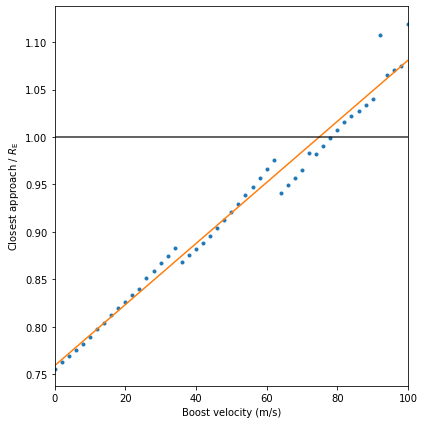

In [20]:
fig, ax = plt.subplots()

fit_x = np.linspace(0.0, 100.0, 101)
fit_y = fit[0] * fit_x + fit[1]

ax.plot(boost_speeds, closest_approaches / R_EARTH, '.')
ax.plot(fit_x, fit_y, '-')

ax.axhline(1.0, color='k', alpha=0.8)
ax.set(xlim=[0, 100], xlabel='Boost velocity (m/s)', ylabel='Closest approach / $R_\mathrm{E}$')
fig.set_size_inches(6, 6)
fig.tight_layout()
plt.show()

In [21]:
# Solve for y = 1
print('Boost velocity = %.2f m/s' % ((1 - fit[1]) / fit[0]))

Boost velocity = 74.89 m/s
